In [1]:
#https://cloud.tencent.com/developer/article/1829770
#original:1, btuB:2, fhuA:3
import sys
import pydot
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn import metrics
from openpyxl import load_workbook
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestRegressor
import joblib
import copy

In [2]:
train_data_path='./iML1515_iMM904_train_data.csv'
test_data_path='./iML1515_iMM904_test_data.csv'
validation_data_path='./iML1515_iMM904_validation_data.csv'
write_excel_path='./RF/ParameterResult_ML.xlsx'
tree_graph_dot_path='./RF/tree.dot'
tree_graph_png_path='./RF/tree.png'

random_seed=44
random_forest_seed=np.random.randint(low=1,high=230)

In [3]:
# Data import

'''
column_name=['E. coli Average abundance','Diffusion coefficient','S. cerevisiae initial abundance standard deviation','S. cerevisiae initial average abundance','Mean deviation of initial abundance of two strains','Group']
'''
train_data=pd.read_csv(train_data_path,header=0)
test_data=pd.read_csv(test_data_path,header=0)
validation_data=pd.read_csv(validation_data_path,header=0)

In [4]:
# Separate independent and dependent variables

train_Y=np.array(train_data['S. cerevisiae Average abundance'])
train_X=train_data.drop(['E. coli Average abundance', 'S. cerevisiae Average abundance'],axis=1)
train_X_column_name=list(train_X.columns)
train_X=np.array(train_X)

test_Y=np.array(test_data['S. cerevisiae Average abundance'])
test_X=test_data.drop(['E. coli Average abundance', 'S. cerevisiae Average abundance'],axis=1)
test_X=np.array(test_X)

validation_Y=np.array(validation_data['S. cerevisiae Average abundance'])
validation_X=validation_data.drop(['E. coli Average abundance', 'S. cerevisiae Average abundance'],axis=1)
validation_X=np.array(validation_X)

In [5]:
number = 20


random_forest_model=RandomForestRegressor(n_estimators=200,random_state=random_forest_seed)
random_forest_model.fit(train_X,train_Y)

# Predict test set data

random_forest_predict=random_forest_model.predict(test_X)
random_forest_error=random_forest_predict-test_Y



# Verify the accuracy

random_forest_pearson_r=stats.pearsonr(test_Y,random_forest_predict)
random_forest_R2=metrics.r2_score(test_Y,random_forest_predict)
random_forest_RMSE=metrics.mean_squared_error(test_Y,random_forest_predict)**0.5


for i in range(number):
    # Build RF regression model

    random_forest_model0=RandomForestRegressor(n_estimators=50,random_state=random_forest_seed)
    random_forest_model0.fit(train_X,train_Y)

    # Predict test set data

    random_forest_predict0=random_forest_model.predict(test_X)
    random_forest_error0=random_forest_predict-test_Y



    # Verify the accuracy

    random_forest_pearson_r0=stats.pearsonr(test_Y,random_forest_predict)
    random_forest_R20=metrics.r2_score(test_Y,random_forest_predict)
    random_forest_RMSE0=metrics.mean_squared_error(test_Y,random_forest_predict)**0.5
    
    if random_forest_RMSE0 > random_forest_RMSE:
        random_forest_model = copy.deepcopy(random_forest_model0)
        random_forest_R2 = copy.deepcopy(random_forest_R20)
        random_forest_pearson_r = copy.deepcopy(random_forest_pearson_r0)
        random_forest_RMSE = copy.deepcopy(random_forest_RMSE0)
        random_forest_predict = copy.deepcopy(random_forest_predict0)
        random_forest_error = copy.deepcopy(random_forest_error0)
    
print('Pearson correlation coefficient is {0}, R2 score is {1}, and RMSE is {2}.'.format(random_forest_pearson_r[0], random_forest_R2, random_forest_RMSE))

# Save key parameters

excel_file=load_workbook(write_excel_path)
excel_all_sheet=excel_file.sheetnames
excel_write_sheet=excel_file[excel_all_sheet[0]]
excel_write_sheet=excel_file.active
max_row=excel_write_sheet.max_row
excel_write_content=[random_forest_pearson_r[0],random_forest_R2,random_forest_RMSE,random_seed,random_forest_seed]
for i in range(len(excel_write_content)):
        exec("excel_write_sheet.cell(max_row+1,i+1).value=excel_write_content[i]")
excel_file.save(write_excel_path)
print(random_forest_predict, '+', test_Y)

Pearson correlation coefficient is 0.8573880326863681, R2 score is 0.470971374268509, and RMSE is 0.01241048101393103.
[0.35456174 0.36385273 0.36429563 0.385938   0.38044379 0.39240459
 0.38422785 0.37036323 0.37163262 0.37739413 0.38223123 0.3605593
 0.39571869] + [0.33724095 0.34346198 0.36659888 0.38957632 0.3804326  0.3908706
 0.37282371 0.37463428 0.34665466 0.36683416 0.36846131 0.35141548
 0.38529543]


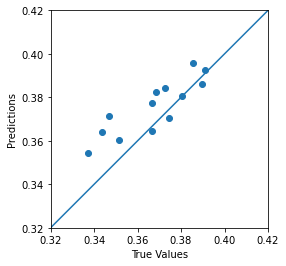

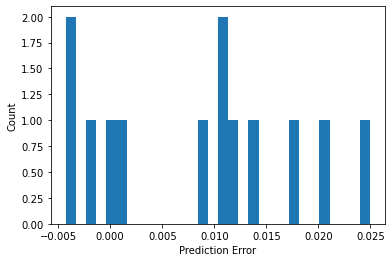

In [6]:
# Draw test plot

plt.figure(1)
plt.clf()
ax=plt.axes(aspect='equal')
plt.scatter(test_Y,random_forest_predict)
plt.xlabel('True Values')
plt.ylabel('Predictions')
Lims=[0.32,0.42]
plt.xlim(Lims)
plt.ylim(Lims)
plt.plot(Lims,Lims)
plt.grid(False)

plt.figure(2)
plt.clf()
plt.hist(random_forest_error,bins=30)
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.grid(False)

In [7]:
# Draw decision tree visualizing plot

random_forest_tree=random_forest_model.estimators_[5]
export_graphviz(random_forest_tree,out_file=tree_graph_dot_path,
                feature_names=train_X_column_name,rounded=True,precision=1)
(random_forest_graph,)=pydot.graph_from_dot_file(tree_graph_dot_path)
random_forest_graph.write_png(tree_graph_png_path)

[0.08162586830625554, 0.6091847371084298, 0.048181886960374856, 0.2219929194207126, 0.03901458820422726]


Text(0.5, 1.0, 'Variable Importances')

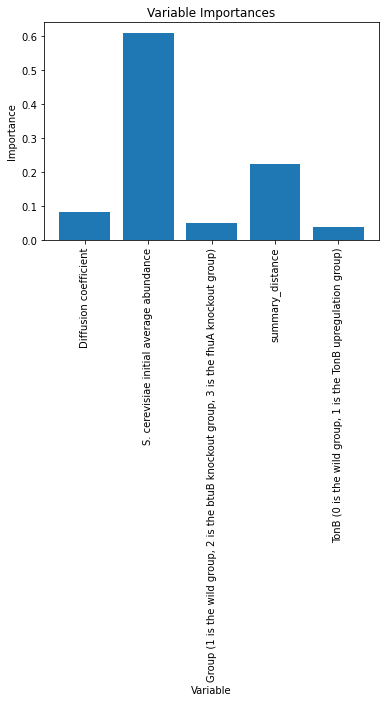

In [8]:
# Calculate the importance of variables

random_forest_importance=list(random_forest_model.feature_importances_)
print(random_forest_importance)
random_forest_feature_importance=[(feature,round(importance,8)) 
                                  for feature, importance in zip(train_X_column_name,random_forest_importance)]
random_forest_feature_importance=sorted(random_forest_feature_importance,key=lambda x:x[1],reverse=True)
plt.figure(3)
plt.clf()
importance_plot_x_values=list(range(len(random_forest_importance)))
plt.bar(importance_plot_x_values,random_forest_importance,orientation='vertical')
plt.xticks(importance_plot_x_values,train_X_column_name,rotation='vertical')
plt.xlabel('Variable')
plt.ylabel('Importance')
plt.title('Variable Importances')

## save
joblib.dump(random_forest_model, "D:\work\metabolic network simulation\polymicrobial system\RF analysis\my_random_forest_3.joblib")

In [9]:
joblib.dump(random_forest_model, "./RF/my_random_forest_1.joblib")

['./RF/my_random_forest_1.joblib']

Pearson correlation coefficient is 0.869443780208538, R2 score is 0.5310325354490977, and RMSE is 0.011684775837675502.


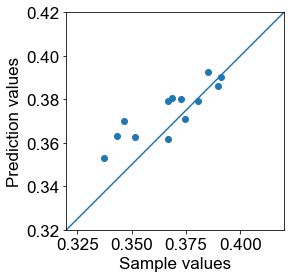

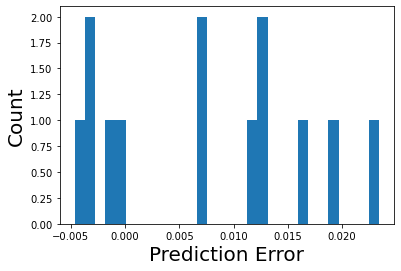

In [10]:
# load
loaded_rf = joblib.load("./RF/my_random_forest.joblib")
test_Y_predict = 1-loaded_rf.predict(test_X)
random_forest_error=test_Y_predict-test_Y

# Verify the accuracy

random_forest_pearson_r=stats.pearsonr(test_Y,test_Y_predict)
random_forest_R2=metrics.r2_score(test_Y,test_Y_predict)
random_forest_RMSE=metrics.mean_squared_error(test_Y,test_Y_predict)**0.5
print('Pearson correlation coefficient is {0}, R2 score is {1}, and RMSE is {2}.'.format(random_forest_pearson_r[0], random_forest_R2, random_forest_RMSE))

# Draw test plot

plt.figure(1)
plt.clf()
ax=plt.axes(aspect='equal')
plt.scatter(test_Y,test_Y_predict)
font = {'family' : 'Arial',
'weight' : 'normal',
'size'   : 17,
}
plt.xlabel('Sample values', font)
plt.ylabel('Prediction values', font)
plt.tick_params(labelsize=17)
labels = ax.get_xticklabels()+ ax.get_yticklabels()
[label.set_fontname('Arial') for label in labels]
Lims=[0.32,0.42]
plt.xlim(Lims)
plt.ylim(Lims)
plt.plot(Lims,Lims)
plt.grid(False)

plt.figure(2)
plt.clf()
plt.hist(random_forest_error,bins=30)
plt.xlabel('Prediction Error', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.grid(False)

[0.08162586830625554, 0.6091847371084298, 0.048181886960374856, 0.2219929194207126, 0.03901458820422726]


Text(0.5, 1.0, 'Variable Importances')

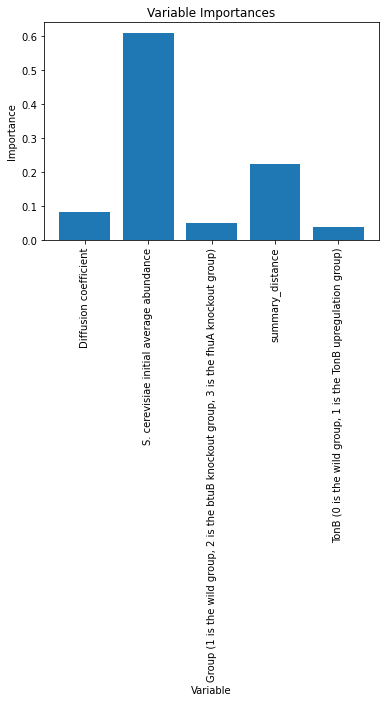

In [11]:
random_forest_importance=list(random_forest_model.feature_importances_)
print(random_forest_importance)
random_forest_feature_importance=[(feature,round(importance,8)) 
                                  for feature, importance in zip(train_X_column_name,random_forest_importance)]
random_forest_feature_importance=sorted(random_forest_feature_importance,key=lambda x:x[1],reverse=True)
plt.figure(3)
plt.clf()
importance_plot_x_values=list(range(len(random_forest_importance)))
plt.bar(importance_plot_x_values,random_forest_importance,orientation='vertical')
plt.xticks(importance_plot_x_values,train_X_column_name,rotation='vertical')
plt.xlabel('Variable')
plt.ylabel('Importance')
plt.title('Variable Importances')

Pearson correlation coefficient is 0.7153456491461226, R2 score is 0.507824706466239, and RMSE is 0.024233792512095394.


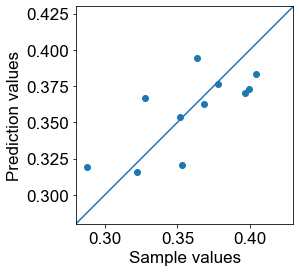

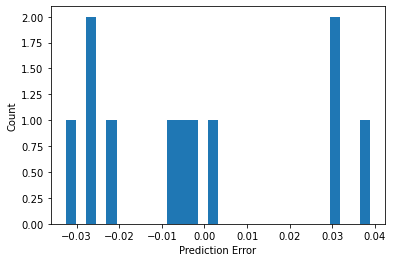

In [12]:
validation_Y_predict = 1-loaded_rf.predict(validation_X)
random_forest_error=validation_Y_predict-validation_Y

# Verify the accuracy

random_forest_pearson_r=stats.pearsonr(validation_Y,validation_Y_predict)
random_forest_R2=metrics.r2_score(validation_Y,validation_Y_predict)
random_forest_RMSE=metrics.mean_squared_error(validation_Y,validation_Y_predict)**0.5
print('Pearson correlation coefficient is {0}, R2 score is {1}, and RMSE is {2}.'.format(random_forest_pearson_r[0], random_forest_R2, random_forest_RMSE))

# Draw validation plot

plt.figure(1)
plt.clf()
ax=plt.axes(aspect='equal')
plt.scatter(validation_Y,validation_Y_predict)
font = {'family' : 'Arial',
'weight' : 'normal',
'size'   : 17,
}
plt.xlabel('Sample values', font)
plt.ylabel('Prediction values', font)
plt.tick_params(labelsize=17)
labels = ax.get_xticklabels()+ ax.get_yticklabels()
[label.set_fontname('Arial') for label in labels]
Lims=[0.28,0.43]
plt.xlim(Lims)
plt.ylim(Lims)
plt.plot(Lims,Lims)
plt.grid(False)

plt.figure(2)
plt.clf()
plt.hist(random_forest_error,bins=30)
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.grid(False)